In [ ]:
########now part 2: decode and train#######

In [1]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

/home/noa_raindel/.TF_cpu_new/lib/python3.5/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 6059017921265522483
]


In [2]:
import tensorflow as tf
import tensorflow.contrib.eager as tfe
import numpy as np
import pandas as pd
import math
import timeit
import matplotlib.pyplot as plt
from tensorflow.contrib.layers.python.layers import utils
#from preprocess_func_new import *
from matplotlib.image import imread
import os
from os.path import expanduser
# from tensorflow.python import keras
# from tensorflow.keras.applications.mobileNet import DepthwiseConv2D

%matplotlib inline

#tf.enable_eager_execution()

#tf.logging.set_verbosity(tf.logging.INFO)

Instructions for updating:
Use the retry module or similar alternatives.


In [3]:
# for auto-reloading external modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

In [4]:
img_path = os.path.join('..','datasets','stixels')
img_path

'../datasets/stixels'

In [5]:
percent=2 

In [6]:
tfrec_batch_size=1 #for path name only

In [7]:
batch_size=64

In [8]:
tfrec_train_directory = os.path.join('..','datasets','stixels','train','tfrec_batch_size_'
                                     +str(tfrec_batch_size)+'_precent_'+str(percent))
#### note there is a misspelling "precent"
tfrec_train_directory


'../datasets/stixels/train/tfrec_batch_size_1_precent_2'

In [9]:
#creating a list of paths to train tfrecs:
path_tfrecords_train_lst=[]
path_tfrecords_train = os.path.join(img_path, 'train')
for root, dirs, files in os.walk(tfrec_train_directory):
    for file in files:
        if '.tfrecord' in file:
            path_tfrecords_train_lst.append(os.path.join(tfrec_train_directory,file))
        else:
            print('WARNING: file ' + file + 'looks suspicious. does it belong here?')


In [10]:
#shortening the list for experiments
path_tfrecords_train_lst = path_tfrecords_train_lst[:128]
##################

In [11]:
#params
H=370 
W=24
C=3
img_shape = (H, W, C)
num_classes = 47

In [12]:
def parse(serialized):
    # Define a dict with the data-names and types we expect to
    # find in the TFRecords file.
    # It is a bit awkward that this needs to be specified again,
    # because it could have been written in the header of the
    # TFRecords file instead.
    features = \
        {
            'image': tf.FixedLenFeature([], tf.string),
            'label': tf.FixedLenFeature([], tf.int64)
        }

    # Parse the serialized data so we get a dict with our data.
    parsed_example = tf.parse_single_example(serialized=serialized,
                                             features=features)

    # Get the image as raw bytes.
    image_raw = parsed_example['image']

    # Decode the raw bytes so it becomes a tensor with type.
    #######image = tf.decode_raw(image_raw, tf.int32) ####
    image = tf.image.decode_png(image_raw, channels=3, dtype=tf.uint8) 
    #image = tf.cast(image, tf.int32)

    # The type is now uint8 but we need it to be float.
    
    image = tf.cast(image, tf.float32) ####
    
    # Get the label associated with the image.
    label = parsed_example['label']

    # The image and label are now correct TensorFlow types.
    return image, label

In [13]:
########## a function to print tensor values
def print_tensor(tensor):
    dataset = tf.data.TFRecordDataset(filenames=[tensor])
    dataset = dataset.map(parse)
    iterator = dataset.make_one_shot_iterator()
    images_batch, labels_batch = iterator.get_next()
    x = {'image': images_batch}
    y = labels_batch
    init_op = tf.initialize_all_variables()

    with tf.Session() as sess:
        sess.run(init_op)
        print (sess.run(y))
        #print (sess.run(x))
        #return(sess.run(x))
    return

In [67]:
################ try to print the tensors
for t in path_tfrecords_train_lst[:128]:
    #print (t)
    print_tensor(t)
    #print(x)

18
19
26
15
17
29
46
15
16
15
14
33
16
30
25
8
21
20
27
32
22
15
31
19
26
9
36
36
16
15
10
24
30
35
10
18
24
16
17
21
36
22
26
10
29
15
20
14
16
12
23
24
38
32
30
23
31
14
16
15
17
17
22
33
12
17
30
13
20
11
35
17
34
11
28
10
15
18
14
46
46
25
16
11
15
16
21
18
33
28
26
11
46
35
24
13
15
10
20
35
21
11
32
27
32
13
21
12
18
35
25
15
21
17
24
26
22
18
19
18
14
29
13
13
22
34
24
17


In [22]:
############# print shape of tensor
x2=tf.Session().run(x['image'])
x2.shape


NameError: name 'x' is not defined

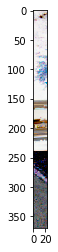

In [107]:
####################. show the parsed stixel
import matplotlib
%matplotlib inline
matplotlib.pyplot.imshow(x2)

In [13]:
def input_fn(filenames, train, batch_size=batch_size, buffer_size=100000): 
    # Args:
    # filenames:   Filenames for the TFRecords files.
    # train:       Boolean whether training (True) or testing (False).
    # batch_size:  Return batches of this size.
    # buffer_size: Read buffers of this size. The random shuffling
    #              is done on the buffer, so it must be big enough.

    # Create a TensorFlow Dataset-object which has functionality
    # for reading and shuffling data from TFRecords files.
    dataset = tf.data.TFRecordDataset(filenames=filenames)

    # Parse the serialized data in the TFRecords files.
    # This returns TensorFlow tensors for the image and labels.
    dataset = dataset.map(parse)
    
    if train:
        # If training then read a buffer of the given size and
        # randomly shuffle it.
        ######dataset = dataset.shuffle(buffer_size=buffer_size)

        # Allow infinite reading of the data.
        num_repeat = None #-1
    else:
        # If testing then don't shuffle the data.
        
        # Only go through the data once.
        num_repeat = 1

    # Repeat the dataset the given number of times.
    dataset = dataset.repeat(num_repeat)
    
    # Get a batch of data with the given size.
    #dataset = dataset.batch(batch_size)
    #dataset = tf.contrib.data.batch_and_drop_remainder(batch_size)
    dataset = dataset.apply(tf.contrib.data.batch_and_drop_remainder(batch_size))
    print('@@@')
    print(dataset.output_shapes)  # ==> "(16,)" (the batch dimension is known)
    print('@@@')
    # Create an iterator for the dataset and the above modifications.
    iterator = dataset.make_one_shot_iterator()

    # Get the next batch of images and labels.
    images_batch, labels_batch = iterator.get_next()

    # The input-function must return a dict wrapping the images.
    x = {'image': images_batch}
    y = labels_batch
    
    return x, y

In [14]:
def train_input_fn():
    return input_fn(filenames=path_tfrecords_train_lst, train=True)

In [15]:
# the next four cells are a modification of https://github.com/xiaochus/MobileNetV2/blob/master/mobilenet_v2.py
def _conv_block(inputs, filters, kernel, strides, is_training):
    """Convolution Block
    This function defines a 2D convolution operation with BN and relu6.
    # Arguments
        inputs: Tensor, input tensor of conv layer.
        filters: Integer, the dimensionality of the output space.
        kernel: An integer or tuple/list of 2 integers, specifying the
            width and height of the 2D convolution window.
        strides: An integer or tuple/list of 2 integers,
            specifying the strides of the convolution along the width and height.
            Can be a single integer to specify the same value for
            all spatial dimensions.
    # Returns
        Output tensor.
    """
    x = tf.layers.conv2d(inputs=inputs, 
                         filters=filters, 
                         kernel_size=kernel,
                         activation=None, 
                         strides=strides,
                         kernel_initializer=tf.contrib.layers.xavier_initializer(seed=481),
                         padding='same'
                        )
    
    x = tf.layers.batch_normalization(inputs=x,
                                      training=is_training
                                     )
    
    x = tf.nn.relu6(features=x)
       
    return x


In [16]:
def _bottleneck(inputs, filters, kernel, t, s, is_training, r=False):
    """Bottleneck
    This function defines a basic bottleneck structure.
    # Arguments
        inputs: Tensor, input tensor of conv layer.
        filters: Integer, the dimensionality of the output space.
        kernel: An integer or tuple/list of 2 integers, specifying the
            width and height of the 2D convolution window.
        t: Integer, expansion factor.
            t is always applied to the input size.
        s: An integer or tuple/list of 2 integers,specifying the strides
            of the convolution along the width and height.Can be a single
            integer to specify the same value for all spatial dimensions.
        r: Boolean, Whether to use the residuals.
    # Returns
        Output tensor.
    """

    
    num_filters_in = utils.last_dimension(inputs.get_shape(), min_rank=4)
    
    # "Expension layer" + BN + activation
    x = _conv_block(inputs=inputs, 
                    filters=num_filters_in*t, 
                    kernel=(1, 1), 
                    strides=(1, 1), 
                    is_training=is_training)
    
    # Depthwise convolution + BN + activation
    x = tf.contrib.layers.separable_conv2d(inputs=x,
                                           num_outputs=None,
                                           kernel_size=kernel,
                                           depth_multiplier=1,
                                           stride=(s,s),
                                           padding='SAME',
                                           activation_fn=tf.nn.relu6,
                                           weights_initializer=tf.contrib.layers.xavier_initializer(seed=481),
                                           normalizer_fn=None
                                          )
     
    x = tf.layers.batch_normalization(inputs=x, 
                                      training=is_training
                                     )
    
    x = tf.nn.relu6(features=x)
    
    # "Projection" layer + BN
    x = tf.layers.conv2d(inputs=x,
                         filters = filters,
                         kernel_size = (1, 1),
                         strides=(1, 1),
                         padding='same',
                         kernel_initializer=tf.contrib.layers.xavier_initializer(seed=481)
                        )
    x = tf.layers.batch_normalization(inputs=x,
                                      training=is_training
                                     )
    
    if r:
        x = tf.add(x, inputs)
        
    '''
    channel_axis = 1 if K.image_data_format() == 'channels_first' else -1
    tchannel = K.int_shape(inputs)[channel_axis] * t
    x = _conv_block(inputs, tchannel, (1, 1), (1, 1))
    x = DepthwiseConv2D(kernel, strides=(s, s), depth_multiplier=1, padding='same')(x)
    x = BatchNormalization(axis=channel_axis)(x)
    x = Activation(relu6)(x)

    x = Conv2D(filters, (1, 1), strides=(1, 1), padding='same')(x)
    x = BatchNormalization(axis=channel_axis)(x)
    '''
    
    return x


In [17]:
def _inverted_residual_block(inputs, filters, kernel, t, strides, n, is_training):
    """Inverted Residual Block
    This function defines a sequence of 1 or more identical layers.
    # Arguments
        inputs: Tensor, input tensor of conv layer.
        filters: Integer, the dimensionality of the output space.
        kernel: An integer or tuple/list of 2 integers, specifying the
            width and height of the 2D convolution window.
        t: Integer, expansion factor.
            t is always applied to the input size.
        s: An integer or tuple/list of 2 integers,specifying the strides
            of the convolution along the width and height.Can be a single
            integer to specify the same value for all spatial dimensions.
        n: Integer, layer repeat times.
    # Returns
        Output tensor.
    """

    x = _bottleneck(inputs=inputs, 
                    filters=filters, 
                    kernel=kernel, 
                    t=t, 
                    s=strides, 
                    is_training=is_training
                   )
        
    for i in range(1, n):
        x = _bottleneck(inputs=x, 
                        filters=filters, 
                        kernel=kernel, 
                        t=t, 
                        s=1, 
                        is_training=is_training, 
                        r=True
                       )

    return x


In [24]:
def MobileNetV2(inputs, k, is_training):
    """MobileNetV2
    This function defines a MobileNetV2 architectures.
    # Arguments
        inputs: A tensor of the input of shape [-1,W,H,C].
        k: Integer, number of classes.
        is_training: boolean indication training or prediction
    # Returns
        MobileNetV2 model.
    """

    
    
    
    x = _conv_block(inputs=inputs, filters=32, kernel=(3, 3), strides=(2, 2), is_training=is_training)
        
    x = _inverted_residual_block(inputs=x, filters=16,  kernel=(3, 3), t=1, strides=1, n=1, is_training=is_training)
    x = _inverted_residual_block(inputs=x, filters=24,  kernel=(3, 3), t=6, strides=2, n=2, is_training=is_training)
    x = _inverted_residual_block(inputs=x, filters=32,  kernel=(3, 3), t=6, strides=2, n=3, is_training=is_training)
    x = _inverted_residual_block(inputs=x, filters=64,  kernel=(3, 3), t=6, strides=2, n=4, is_training=is_training)
#     x = _inverted_residual_block(inputs=x, filters=96,  kernel=(3, 3), t=6, strides=1, n=3, is_training=is_training)
#     x = _inverted_residual_block(inputs=x, filters=160, kernel=(3, 3), t=6, strides=2, n=3, is_training=is_training)
#     x = _inverted_residual_block(inputs=x, filters=320, kernel=(3, 3), t=6, strides=1, n=1, is_training=is_training)
    
    # Eventually this should be replaced with:
    x = tf.layers.flatten(x)


    # This is the last layer so it does not use an activation function.
    x = tf.layers.dense(inputs=x, name='layer_fc6',
                          units=k,
                          kernel_initializer=tf.contrib.layers.xavier_initializer()
                          ) 
    '''
    x = _conv_block(inputs=x, filters=1280, kernel=(1, 1), strides=(1, 1), is_training=is_training)
    x = tf.layers.average_pooling2d(inputs=x, pool_size=(2000,2000), strides=(1,1), padding='same')
    x = tf.reshape(x, [-1,1,1,1280])
    #x = tf.layers.dropout(inputs=x, rate=0.3, seed=481, training=is_training)
    x = tf.layers.conv2d(inputs=x,
                         filters = k,
                         kernel_size = (1, 1),
                         padding='same',
                         kernel_initializer=tf.contrib.layers.xavier_initializer(seed=481)
                        )
    '''
    '''
    x = GlobalAveragePooling2D()(x)
    x = Reshape((1, 1, 1280))(x)
    x = Dropout(0.3, name='Dropout')(x)
    x = Conv2D(k, (1, 1), padding='same')(x)
    x = Activation('softmax', name='softmax')(x)
    output = Reshape((k,))(x)
    '''
    

    return x

In [19]:
def model_fn(features, labels, mode, params):
    # Args:
    #
    # features: This is the x-arg from the input_fn.
    # labels:   This is the y-arg from the input_fn.
    # mode:     Either TRAIN, EVAL, or PREDICT
    # params:   User-defined hyper-parameters, e.g. learning-rate.
    
   
    if mode == tf.estimator.ModeKeys.TRAIN:
        is_training = True
    else:
        is_training = False
    
    # Reference to the tensor named "image" in the input-function.    
    x = features["image"]
    # The convolutional layers expect 4-rank tensors
    # but x is a 2-rank tensor, so reshape it.
    inputs = tf.reshape(x, [-1,W,H,C])
    
    net = MobileNetV2(inputs=inputs, k=47, is_training=is_training)
    
    '''
    # First convolutional layer.
    net = tf.layers.conv2d(inputs=net, name='layer_conv1',
                           filters=32, kernel_size=(3,3),
                           activation=tf.nn.leaky_relu, strides=(2,2),
                           kernel_initializer=tf.contrib.layers.xavier_initializer(seed=481)
                           )
    net = tf.layers.separable_conv2d(inputs=net, filters=32,kernel_size=(3,3), strides=(1, 1),
                               activation=tf.nn.leaky_relu,
                               depthwise_initializer=tf.contrib.layers.xavier_initializer(seed=481),
                               pointwise_initializer=tf.contrib.layers.xavier_initializer(seed=481),
                               name='layer_conv_dw2',
                              )
    
    net = tf.layers.separable_conv2d(inputs=net, filters=64,kernel_size=(3,3), strides=(2,2),
                               activation=tf.nn.leaky_relu,
                               depthwise_initializer=tf.contrib.layers.xavier_initializer(seed=481),
                               pointwise_initializer=tf.contrib.layers.xavier_initializer(seed=481),
                               name='layer_conv_dw3',
                              )

    net = tf.layers.separable_conv2d(inputs=net, filters=128,kernel_size=(3,3), strides=(1,1),
                               activation=tf.nn.leaky_relu,
                               depthwise_initializer=tf.contrib.layers.xavier_initializer(seed=481),
                               pointwise_initializer=tf.contrib.layers.xavier_initializer(seed=481),
                               name='layer_conv_dw4',
                              )
    net = tf.layers.average_pooling2d(inputs=net, pool_size=(2,88), strides=(1,1), name='layer_pool5')
    
    # Flatten to a 2-rank tensor.
    #net = tf.contrib.layers.flatten(net)
    # Eventually this should be replaced with:
    net = tf.layers.flatten(net)


    # This is the last layer so it does not use an activation function.
    net = tf.layers.dense(inputs=net, name='layer_fc6',
                          units=47,
                          kernel_initializer=tf.contrib.layers.xavier_initializer()
                          ) 
    '''
    
    # Logits output of the neural network.
    logits = net

    # Softmax output of the neural network.
    y_pred = tf.nn.softmax(logits=logits)
    
    # Classification output of the neural network.
    y_pred_cls = tf.argmax(y_pred, axis=1) 
   
    if mode == tf.estimator.ModeKeys.PREDICT:
        # If the estimator is supposed to be in prediction-mode
        # then use the predicted class-number that is output by
        # the neural network. Optimization etc. is not needed.
        
        spec = tf.estimator.EstimatorSpec(mode=mode,
                                          predictions=y_pred)# _cls)
    else:
        # Otherwise the estimator is supposed to be in either
        # training or evaluation-mode. Note that the loss-function
        # is also required in Evaluation mode.
        
        # Define the loss-function to be optimized, by first
        # calculating the cross-entropy between the output of
        # the neural network and the true labels for the input data.
        # This gives the cross-entropy for each image in the batch.
        cross_entropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=labels,
                                                                       logits=logits)

        # Reduce the cross-entropy batch-tensor to a single number
        # which can be used in optimization of the neural network.
        tf.argmax(logits)
        #loss = tf.losses.mean_squared_error(labels=labels, predictions=logits)
        loss = tf.reduce_mean(cross_entropy)
#######################
        lr = 1e-1
        step_rate = 1000
        decay = 0.5 #if this equals 1 the lr stays the same

        #global_step = tf.Variable(0, trainable=False)
        #increment_global_step = tf.assign(global_step, global_step + 1)

        learning_rate = tf.train.exponential_decay(lr, global_step=tf.train.get_or_create_global_step(), 
                                           decay_steps=step_rate, decay_rate=decay, staircase=True)
        
        # Define the optimizer for improving the neural network.
        #optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
        optimizer = tf.train.GradientDescentOptimizer(learning_rate=learning_rate) 
        
        ''' original
        # Get the TensorFlow op for doing a single optimization step.
        train_op = optimizer.minimize(loss=loss, global_step = tf.train.get_or_create_global_step())
        '''
        # for learning parameters of batch normalization:
        update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
        with tf.control_dependencies(update_ops):
            train_op = optimizer.minimize(loss, global_step=tf.train.get_or_create_global_step())
        
        
#############################        


        # Define the evaluation metrics,
        # in this case the classification accuracy.
        metrics = \
        {
            "accuracy": tf.metrics.accuracy(labels, y_pred_cls) #TODO change acc method
        }

        # Wrap all of this in an EstimatorSpec.
        spec = tf.estimator.EstimatorSpec(
            mode=mode,
            loss=loss,
            train_op=train_op,
            eval_metric_ops=metrics)
        
    return spec

In [20]:
params = {} #{"learning_rate": 1e-5}

In [21]:
def make_dir_and_comment(model_dir):
    home = expanduser("~")
    log_name=os.path.join('logs/', model_dir + '.txt')
    
    if os.path.isdir(model_dir):
        print('INFO: dir with name ' + model_dir + ' already exist.')
    
    new_comment=input('Please add a comment\n')
    
    if os.path.exists(log_name):
        append_write = 'a' # append if already exists
    else:
        append_write = 'w' # make a new file if not
    
    model_log = open(log_name,append_write)
    model_log.write(home +' : '+ new_comment + '\n')
    model_log.close()
    return



In [25]:
model_dir = './ckpts_27_5_mobilenetV2_partial_midSize2_128examples' #'./ckpts_<day>_<month>_<architecture>_<main_change>'
make_dir_and_comment(model_dir) 
model = tf.estimator.Estimator(model_fn=model_fn,
                               params=params,
                               model_dir=model_dir)

Please add a comment
fully connected in the last layer
INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_num_worker_replicas': 1, '_model_dir': './ckpts_27_5_mobilenetV2_partial_midSize2_128examples', '_log_step_count_steps': 100, '_keep_checkpoint_every_n_hours': 10000, '_save_checkpoints_secs': 600, '_session_config': None, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7f86b87f6518>, '_save_checkpoints_steps': None, '_is_chief': True, '_task_type': 'worker', '_task_id': 0, '_tf_random_seed': None, '_evaluation_master': '', '_keep_checkpoint_max': 5, '_num_ps_replicas': 0, '_global_id_in_cluster': 0, '_master': '', '_save_summary_steps': 100}


In [26]:
model.train(input_fn=train_input_fn, steps=8000)

@@@
(TensorShape([Dimension(64), Dimension(None), Dimension(None), Dimension(3)]), TensorShape([Dimension(64)]))
@@@
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 1 into ./ckpts_27_5_mobilenetV2_partial_midSize2_128examples/model.ckpt.
INFO:tensorflow:loss = 8.730365, step = 1
INFO:tensorflow:global_step/sec: 0.197717
INFO:tensorflow:loss = 0.018775066, step = 101 (505.776 sec)


KeyboardInterrupt: 

In [115]:
###DONE TRAIN###

In [ ]:
#VAL:

In [41]:
tfrec_val_batch_size=1

In [46]:
tfrec_val_directory = os.path.join('..','datasets','stixels','val','tfrec_batch_size_'+str(tfrec_val_batch_size))#+'_percent_'+str(percent))

In [48]:
path_tfrecords_val_lst=[]
path_tfrecords_val = os.path.join(img_path, 'val')
for root, dirs, files in os.walk(tfrec_val_directory):
    for file in files:
        if '.tfrecord' in file:
            path_tfrecords_val_lst.append(os.path.join(tfrec_val_directory,file))
        else:
            print('WARNING: file ' + file + 'looks suspicious. does it belong here?')

In [49]:
path_tfrecords_val_lst



['../datasets/stixels/val/tfrec_batch_size_1/val021379.tfrecords',
 '../datasets/stixels/val/tfrec_batch_size_1/val044008.tfrecords',
 '../datasets/stixels/val/tfrec_batch_size_1/val103765.tfrecords',
 '../datasets/stixels/val/tfrec_batch_size_1/val000285.tfrecords',
 '../datasets/stixels/val/tfrec_batch_size_1/val024869.tfrecords',
 '../datasets/stixels/val/tfrec_batch_size_1/val075925.tfrecords',
 '../datasets/stixels/val/tfrec_batch_size_1/val096073.tfrecords',
 '../datasets/stixels/val/tfrec_batch_size_1/val078704.tfrecords',
 '../datasets/stixels/val/tfrec_batch_size_1/val070831.tfrecords',
 '../datasets/stixels/val/tfrec_batch_size_1/val088318.tfrecords',
 '../datasets/stixels/val/tfrec_batch_size_1/val047893.tfrecords',
 '../datasets/stixels/val/tfrec_batch_size_1/val057968.tfrecords',
 '../datasets/stixels/val/tfrec_batch_size_1/val041699.tfrecords',
 '../datasets/stixels/val/tfrec_batch_size_1/val114648.tfrecords',
 '../datasets/stixels/val/tfrec_batch_size_1/val034548.tfrecor

In [60]:
def val_input_fn():
    return input_fn(path_tfrecords_train_lst, train=False) #path_tfrecords_val_lst[7000:8500], train=False) 

In [61]:
path_tfrecords_train_lst

['../datasets/stixels/train/tfrec_batch_size_1_percent_2/train134319.tfrecords',
 '../datasets/stixels/train/tfrec_batch_size_1_percent_2/train041626.tfrecords',
 '../datasets/stixels/train/tfrec_batch_size_1_percent_2/train327806.tfrecords',
 '../datasets/stixels/train/tfrec_batch_size_1_percent_2/train088905.tfrecords']

In [62]:
val_result = model.evaluate(input_fn=val_input_fn) 

(TensorShape([Dimension(64), Dimension(None), Dimension(None), Dimension(3)]), TensorShape([Dimension(64)]))
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2018-05-25-07:56:59
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from ./ckpts_22_5_1conv_1dense_4examples/model.ckpt-10649
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Finished evaluation at 2018-05-25-07:56:59
INFO:tensorflow:Saving dict for global step 10649: accuracy = 0.0, global_step = 10649, loss = 0.0


In [36]:
val_result

{'accuracy': 0.046195652, 'global_step': 10649, 'loss': 262.73007}

In [37]:
print("Classification val accuracy: {0:.2%}".format(val_result["accuracy"]))

Classification val accuracy: 4.62%


In [ ]:
#TEST:

In [104]:
tfrec_test_batch_size=1

In [105]:
tfrec_test_directory = os.path.join('..','datasets','stixels','test','tfrec_batch_size_'+str(tfrec_test_batch_size))

In [106]:
path_tfrecords_test_lst=[]
path_tfrecords_test = os.path.join(img_path, 'test')
for root, dirs, files in os.walk(tfrec_test_directory):
    for file in files:
        if '.tfrecord' in file:
            path_tfrecords_test_lst.append(os.path.join(tfrec_test_directory,file))
        else:
            print('WARNING: file ' + file + 'looks suspicious. does it belong here?')

In [107]:
def test_input_fn():
    return input_fn(filenames=path_tfrecords_test_lst[1000:3000], train=False)

In [108]:
test_result = model.evaluate(input_fn=test_input_fn)

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2018-05-22-07:33:49
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from ./ckpts_15_5_decay_xavier_grad_decsent_example7/model.ckpt-24001
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Finished evaluation at 2018-05-22-07:34:22
INFO:tensorflow:Saving dict for global step 24001: accuracy = 0.1155, global_step = 24001, loss = 4.1837482


In [109]:
print("Classification test accuracy: {0:.2%}".format(test_result["accuracy"]))

Classification test accuracy: 11.55%


In [ ]:
#PRED:

In [38]:
sum_csv_test_path = os.path.join(img_path,'train', 'sum_csv') #TEST
labels_test=pd.read_csv(os.path.join(sum_csv_test_path,'labels_train_'+str(percent)+'percent.csv'))
test_names_list=list(labels_test['Name'])
image_paths_test=[]
for name in test_names_list:
    image_paths_test.append(os.path.join(img_path, 'train', name+'.png')) #maybe no need to add '.png'


In [39]:
def load_images(image_paths):
    # Load the images from disk.
    images = [imread(path) for path in image_paths]
    # Convert to a numpy array and return it.
    return np.asarray(images)


In [40]:
##TODO:SHUFFLE!
some_num=100
some_images = load_images(image_paths=image_paths_test[0:0+some_num])
some_images_cls = np.array(labels_test['Label'])

In [41]:
predict_input_fn = tf.estimator.inputs.numpy_input_fn(
    x={"image": some_images.astype(np.float32)},
    num_epochs=1,
    shuffle=False)

In [42]:
predictions = model.predict(input_fn=predict_input_fn) 

In [43]:
cls_pred = np.array(list(predictions))
cls_pred 

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from ./ckpts_22_5_1conv_1dense_4examples/model.ckpt-10649
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.


array([[0.01173844, 0.02670282, 0.00659254, ..., 0.01886446, 0.02820454,
        0.03022418],
       [0.01164605, 0.02677397, 0.00646833, ..., 0.01912687, 0.02771651,
        0.03033716],
       [0.0114068 , 0.02712762, 0.00640529, ..., 0.019169  , 0.02678959,
        0.0310404 ],
       ...,
       [0.01041822, 0.02845204, 0.00574676, ..., 0.0181485 , 0.0275079 ,
        0.03119214],
       [0.01022478, 0.02874675, 0.00587737, ..., 0.01858109, 0.02821582,
        0.0311498 ],
       [0.01039221, 0.02890631, 0.00591503, ..., 0.01886374, 0.02799399,
        0.03109998]], dtype=float32)

In [44]:
cls_pred.shape

(100, 47)

In [45]:
cls_pred

array([[0.01173844, 0.02670282, 0.00659254, ..., 0.01886446, 0.02820454,
        0.03022418],
       [0.01164605, 0.02677397, 0.00646833, ..., 0.01912687, 0.02771651,
        0.03033716],
       [0.0114068 , 0.02712762, 0.00640529, ..., 0.019169  , 0.02678959,
        0.0310404 ],
       ...,
       [0.01041822, 0.02845204, 0.00574676, ..., 0.0181485 , 0.0275079 ,
        0.03119214],
       [0.01022478, 0.02874675, 0.00587737, ..., 0.01858109, 0.02821582,
        0.0311498 ],
       [0.01039221, 0.02890631, 0.00591503, ..., 0.01886374, 0.02799399,
        0.03109998]], dtype=float32)

In [46]:
np.histogram(cls_pred, bins=47)

(array([ 52, 107, 108,  75, 150, 154, 159, 263, 344, 371, 133, 216, 256,
        234, 292, 180,  95, 162, 283, 281, 250,  78,  52,  47,  52,  44,
         54,  37,  31,  17,  19,  13,  16,   9,   7,  12,   2,  14,   6,
          8,   5,   3,   1,   2,   1,   2,   3]),
 array([0.00291326, 0.00426659, 0.00561992, 0.00697324, 0.00832657,
        0.0096799 , 0.01103322, 0.01238655, 0.01373988, 0.0150932 ,
        0.01644653, 0.01779986, 0.01915318, 0.02050651, 0.02185984,
        0.02321316, 0.02456649, 0.02591982, 0.02727314, 0.02862647,
        0.0299798 , 0.03133312, 0.03268645, 0.03403978, 0.0353931 ,
        0.03674643, 0.03809976, 0.03945308, 0.04080641, 0.04215974,
        0.04351306, 0.04486639, 0.04621972, 0.04757304, 0.04892637,
        0.0502797 , 0.05163302, 0.05298635, 0.05433968, 0.055693  ,
        0.05704633, 0.05839966, 0.05975298, 0.06110631, 0.06245964,
        0.06381296, 0.06516629, 0.06651962]))

In [47]:
cls_pred[11]

array([0.01013887, 0.02969489, 0.0061564 , 0.02119487, 0.01757099,
       0.02901325, 0.03026538, 0.02745966, 0.02374774, 0.0297063 ,
       0.02675543, 0.03371446, 0.02226516, 0.01580071, 0.01447017,
       0.03927152, 0.01527348, 0.00865516, 0.04348044, 0.04089904,
       0.02201671, 0.01601022, 0.02277997, 0.01496616, 0.01107511,
       0.01454198, 0.02906439, 0.00800654, 0.01769709, 0.02235518,
       0.0306834 , 0.02337936, 0.01381616, 0.02831054, 0.01072191,
       0.00529775, 0.01853069, 0.01654931, 0.01888733, 0.02299123,
       0.01493914, 0.01928054, 0.01303973, 0.02092779, 0.01887416,
       0.02674274, 0.03298091], dtype=float32)

In [48]:
y_pred_cls = tf.argmax(cls_pred, axis=1) 

In [49]:
y_pred_cls

<tf.Tensor 'ArgMax:0' shape=(100,) dtype=int64>

In [50]:
init_op = tf.initialize_all_variables()
with tf.Session() as sess:
        sess.run(init_op)
        print (sess.run(y_pred_cls))

[18 18 18 18 18 18 18 18 18 18 18 18 19 19 18 18 18 18 18 18 18 18 18 18
 18 18 18 18 18 18 18 18 18 18 18 18 18 18 15 19 19 19 19 18 18 18 18 18
 18 18 18 18 18 18 18 18 19 19 18 18 18 18 18 18 18 18 18 18 18 18 18 18
 18 18 18 18 18 18 18 18 18 18 18 18 18 19 19 19 19 19 18 18 18 18 18 18
 18 18 18 18]
